# Basic Implementation of Support Vector Machine with Non-Separable Samples

The aim of this program is to demonstrate a basic example of the use of a Support Vector Machine (SVM) classifier with non-separable data. Hard-margin SVM classifiers can only be utilised with separable samples, which is problematic as most real-world data is non-separable. However, soft-margin SVM classifiers can be used with non-separable data, employing slack variables to permit training samples to lie within the margin. 

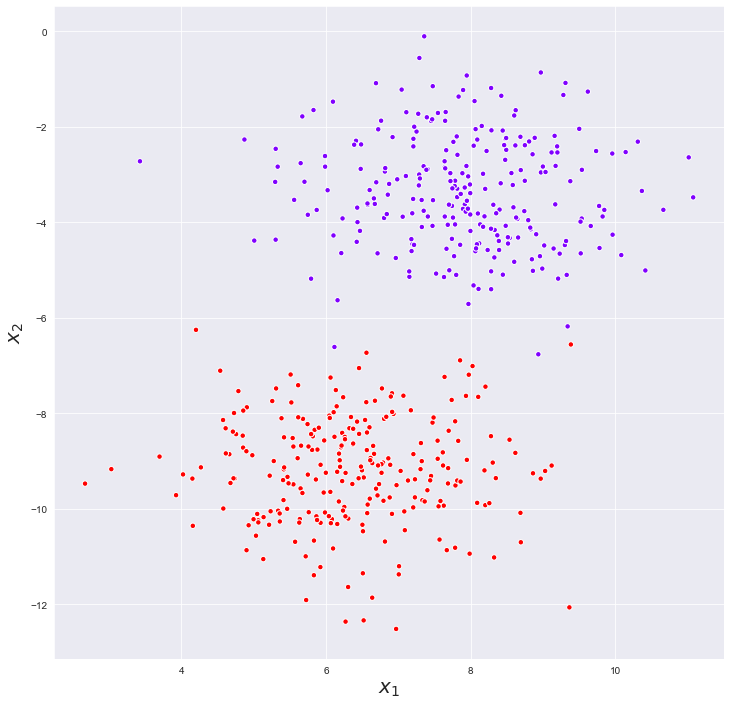

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# generate data set at random: 500 points, 2 clusters
X, y = make_blobs(n_samples = 500, centers = 2, random_state = 6,
                  cluster_std = 1.2)

# plot data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'rainbow', s = 30,
           edgecolors = 'white')
ax.set_xlabel(r'$x_1$', fontsize = 20)
ax.set_ylabel(r'$x_2$', fontsize = 20)
plt.show()

When using soft-margin SVM classifiers with non-separable samples it is important to use regularisation. Large values of the regularisation parameter C result in severe penalties for misclassifications and complex hyperplanes, whereas very small values of C allow large misclassifications and lead to simple hyperplanes. Our goal is to identify the optimal value of C for balancing maximum margin width with the number of misclassifications.

We begin by defining a grid of C values to search amongst using GridSearchCV. As none of the internal scoring metrics are suited to SVM classifiers, we will define our own metric which subtracts the number of misclassifications (divided by total number of training samples) from 1. Hence, the C value which produces the least misclassification will score the highest.

In [24]:
# Find the optimal C regularisation parameter
c_space = np.logspace(-2, 2, 50)
param_grid = {'C': c_space}

# define scoring metric for GridSearchCV
def margin_accuracy(svc, X, y):
    # ~np.any(y == -1) returns False if y contains a -1 and True if it does not
    # any value that is not -1 , is multiplied by 2 and has 1 subtracted
    # the y array of 0s and 1s is converted into an array of -1s and 1s with -1s replacing the 0s
    if ~np.any(y == -1): y = 2 * y - 1
    # N = number of samples
    N = y.shape[0]
    # decision_function tells us on which side of the hyperplane a sample lies and how far away it is from the hyperplane
    # svc.decision_function(X) < 1 selects any sample that is returned a value less than 1 (the positive margin). 
    # the boolean value True is assigned to any sample not lying 'above' the positive margin given by w.x + b = 1
    # y * svc.decision_function(X) < 1 only returns non-zero values (of 1) when for a particular sample y is 1 and
    # svc.decision_function(X) < 1 is True
    # this corresponds to an example having the actual value of 1 and being misclassified
    # fp_fn counts the number of misclassifications
    fp_fn = np.sum(y * svc.decision_function(X) < 1)
    # as fp_fn increases the scoring metric decreases
    return 1 - fp_fn / N

Next we fit GridSearchCV to the training data, identify the optimal value of C and assign it to a newly created SVM classifier. We fit this classifier to the training data in order to plot the hyperplane corresponding to our selected C. 

In [25]:
svc_cv = GridSearchCV(svc, param_grid, scoring = margin_accuracy, cv = 5)
svc_cv.fit(X, y)
c = svc_cv.best_params_['C']
# create SVM classifier and assign it the optimal C value
svc = SVC(kernel = 'linear')
svc.C = c
# train classifier on data
svc.fit(X, y)

SVC(C=2.811768697974228, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Now we will add the hyperplane, margins and support vectors to the plot. 

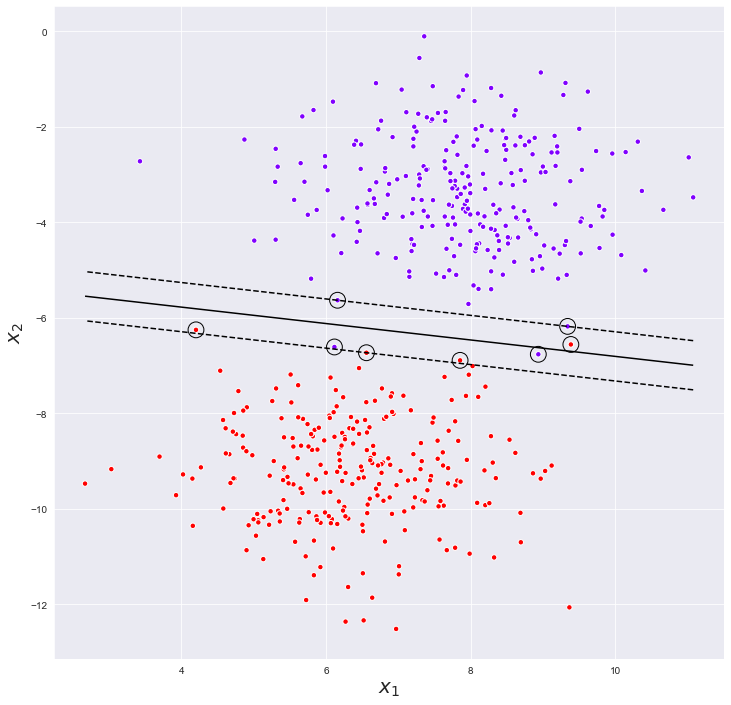

In [26]:
# add plot
fig2 = plt.figure(figsize = (12, 12))
ax2 = fig2.add_subplot(111)
ax2.scatter(X[:,0], X[:,1], c = y, cmap = 'rainbow', s = 30,
           edgecolors = 'white')
ax2.set_xlabel(r'$x_1$', fontsize = 20)
ax2.set_ylabel(r'$x_2$', fontsize = 20)

# plot decision boundary
# this is done with a contour plot which requires a grid to be generated with np.meshgrid
x1_min = min(X[:,0])
x1_max = max(X[:,0])
x2_min = min(X[:,1])
x2_max = max(X[:,1])
x1 = np.linspace(x1_min, x1_max, 100)
x2 = np.linspace(x2_min, x2_max, 100)
# generate a grid of x and y points
X1, X2 = np.meshgrid(x1, x2)
# arrange into a format that can be accepted by sklearn
# unravel X1 and Y1 into 1D arrays and vertically stack them
points = np.vstack([X1.ravel(), X2.ravel()]).T
# evaluate the decision function for 'points' and reshape into the shape of the grid
boundary = svc.decision_function(points).reshape(X1.shape)
# decision boundary occurs at w*x+b=0
# margins occur at w*x+b=1 and w*x+b=-1
# these are represented by the contour levels
ax2.contour(X1, X2, boundary, colors = 'k', levels = [-1, 0, 1],
           linestyles = ['--', '-', '--'])
# get support vectors
support_vecs = svc.support_vectors_
# plot support vectors
ax2.scatter(support_vecs[:,0], support_vecs[:,1], s = 250, linewidth = 1,
           facecolors = 'none', edgecolors = 'k')

To finish off we print the optimal value of C and identify the misclassified training samples.

In [27]:
print('Optimal regularisation parameter C = {:.2f}'.format(c))
print('Misclassified samples:')
# identify misclassified training samples
y_pred = svc.predict(X)
misclassifications = np.argwhere(y != y_pred)
for index in misclassifications:
    i = index[0]
    print('({:.2f}, {:.2f})'.format(X[i][0], X[i][1]))

Optimal regularisation parameter C = 2.81
Misclassified samples:
(6.12, -6.61)
(9.39, -6.56)
(8.94, -6.76)
